In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from validphys.loader import FallbackLoader as Loader
from validphys.api import API

# Settings and fit names

In [2]:
use_t0 = False #set use_t0 for all the notebook
NDATA = 4616 #number of data in the fit
VARCHI2 = 1.0 / NDATA #Varchi2 normalized to ndata

In [3]:
config_common = {"dataset_inputs":{"from_": "fit"}, "datacuts":{"from_":"fit"}, "use_cuts":{"from_": "datacuts"}, "fakepdf":{"from_":"closuretest"}, "theory":{"from_":"fit"}, "theoryid":{"from_":"theory"}, "pdf":{"from_": "fit"}, "closuretest":{"from_": "fit"}, "filterseed":{"from_":"closuretest"}, "use_fitcommondata": True, "use_t0": use_t0, "t0pdfset":{"from_":"datacuts"} }

In [4]:
# fit_names = [f"NNPDF40_nnlo_as_0{n}_corr_s{l}" for l in "12" for n in [1140,1150,1160,1170,1175,1180,1185,1190,1195,1200,1210,1220]]

#NOTE: 0.1990 was mistakenly done with theoryID 0.0120 instead
#fit_names = [f"240218-rs-nnpdf40-corr-mhou-0{n}" for n in range(1140,1220+1,10)]
# fit_names = [f"240219-rs-nnpdf40-corr-0{n}" for n in range(1140,1220+1,10)]
# Closure fit names (not iterated and no MHOU)

#fit_names = [f"240301-ab-ct-alphas{n}-noMHOU" for n in range(114, 122+1, 1)] #ct-results
#fit_names = [f"240306-ab-ct-alphas{n}-noMHOU_t0sampling" for n in range(114, 122+1, 1)] #ct-results with t0 also in sampling
fit_names = [f"240311-ab-ct-alphas{n}-noMHOU_DIS" for n in range(114, 122+1, 1)] #ct-results DIS-only
#fit_names = [f"240311-ab-ct-alphas{n}-noMHOU_DIS_noGPOS" for n in range(114, 122+1, 1)] #ct-results DIS-only, no gluon Positivity


# Loading the fits

In [5]:
l = Loader()
fits = [l.check_fit(f) for f in fit_names]

In [6]:
from collections import defaultdict
as_fits = defaultdict(list)
for f in fits:
    th = f.as_input()["theory"]["theoryid"]
    alpha = float(API.theory_info_table(theory_db_id = th).loc["alphas"])
    as_fits[alpha].append(f)
as_fits = dict(as_fits)

In [7]:
indexes = {f: API.fitted_replica_indexes(pdf=f.name) for f in fits}
replica_data = {f: API.replica_data(fit=f.name) for f in fits}

# Correlated replica method (CRM)

# Some useful functions

In [8]:
def measure(replica_data):
    return replica_data.training*3 + replica_data.validation*1
    # return replica_data.chi2
def fit_parabola(data, exp=False):
    mins = {}
    for ind, row in data.iterrows():
        a, b, c = np.polyfit(data.columns, row, 2)
        if not np.isnan(b): # NaN if not all replicas passed postfit
            mins[ind] = -b / 2 / a
        # mins[ind] = data.columns[np.where(row==row.min())][0]
    mins = pd.Series(mins)
    if exp: 
        uncer = np.sqrt(VARCHI2/a)
        plt.scatter(data.columns,data.values, color="blue" )
        plt.plot(np.linspace(0.114, 0.122), [a*x*x + b*x + c for x in np.linspace(0.114, 0.122)], color="black", linestyle="--")
        return mins[0], uncer
    return mins
def describe_results(mins):
    print(mins.describe(percentiles=[0.16,0.84]))
    print("")
    print(f"cv±std = {mins.mean():.5f} ± {mins.std():.5f} ")
    print(f"1std interval:  {mins.mean()-mins.std():.5f} to {mins.mean()+mins.std():.5f} ")
    print(f"68% c.i:        {mins.describe(percentiles=[0.16,0.84])[4]:.5f} to {mins.describe(percentiles=[0.16,0.84])[6]:.5f} ")
def plot_results(mins):
    from validphys.plotutils import kde_plot
    fig, ax = plt.subplots()
    kde_plot(mins,ax=ax)
    central = (mins.describe(percentiles=[0.16,0.84])[6] + mins.describe(percentiles=[0.16,0.84])[4])/2
    unc = (mins.describe(percentiles=[0.16,0.84])[6] - mins.describe(percentiles=[0.16,0.84])[4])/2
    ax.set_title(f"68% c.i: {central:.5f}  ± {unc:.5f}  -- MHOU")
    #ax.set_xlim(0.118,0.13)
    ax.set_xlabel(r"$\alpha_s$")
def hist_results(mins, data, namefig=None):
    plt.hist(mins,bins=data.columns-0.0005,edgecolor='black',density=True)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    from scipy.stats import norm
    # p = np.exp(-((x-mins.mean())/mins.std())**2/2)*mins.size/np.sqrt(2*np.pi)
    p = norm.pdf(x, mins.mean(), mins.std())
    plt.plot(x,p,'k',label=f"{mins.mean():.5f} +/- {mins.std():.5f}")
    plt.yticks([])
    plt.legend()
    if namefig is not None:
        plt.savefig(namefig)

## Compute the chi2 a posteriori for the CRM
This is done in such a way we are free to use or not the t0 prescription

In [9]:
replica_chi2_crm = {}
for alpha, flist in as_fits.items():
    chi2s_replica = []
    for f in flist:
        config_common["fit"] = f.name
        config_common["fits"] = [f.name] #This is used only to load replica 1 data, and it currently needs a list of fits
        chi2s_replica.append(pd.Series(API.replica_chi2_level1(**config_common), index=indexes[flist[0]])) #This function is only present in the branch closure_with_same_level1
    replica_chi2_crm[alpha] = pd.DataFrame(chi2s_replica).min() #NB: We do the min here. Should we instead do the mean?
data_crm_posteriori = pd.DataFrame(replica_chi2_crm)

LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas114-noMHOU_DIS
240311-ab-ct-alphas114-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas115-noMHOU_DIS
240311-ab-ct-alphas115-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas116-noMHOU_DIS
240311-ab-ct-alphas116-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas117-noMHOU_DIS
240311-ab-ct-alphas117-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas118-noMHOU_DIS
240311-ab-ct-alphas118-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas119-noMHOU_DIS
240311-ab-ct-alphas119-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 240311-ab-ct-alphas120-noMHOU_DIS
240311-ab-ct-alphas120-noMHOU_DIS, version 1; 101 PDF members
LHAPDF 6.4.0 loading all 101 PDFs in set 

In [10]:
mins_crm_posteriori = fit_parabola(data_crm_posteriori)
describe_results(mins_crm_posteriori)

count    91.000000
mean      0.118199
std       0.011722
min       0.048488
16%       0.115511
50%       0.117517
84%       0.119816
max       0.183115
dtype: float64

cv±std = 0.11820 ± 0.01172 
1std interval:  0.10648 to 0.12992 
68% c.i:        0.11551 to 0.11982 


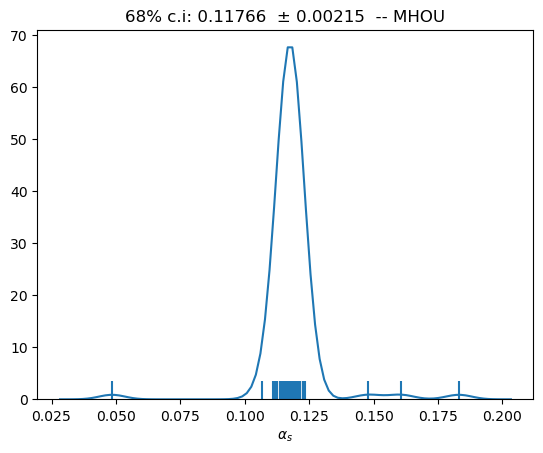

In [16]:
plot_results(mins_crm_posteriori)

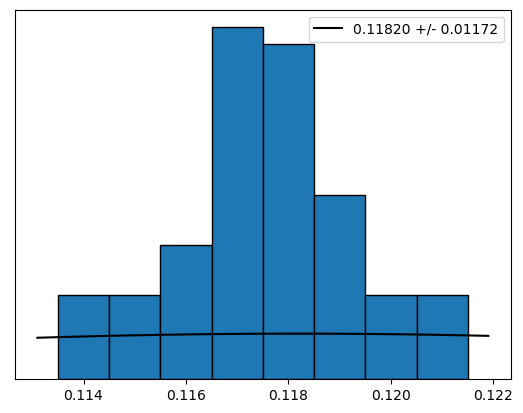

In [12]:
hist_results(mins_crm_posteriori, data_crm_posteriori)

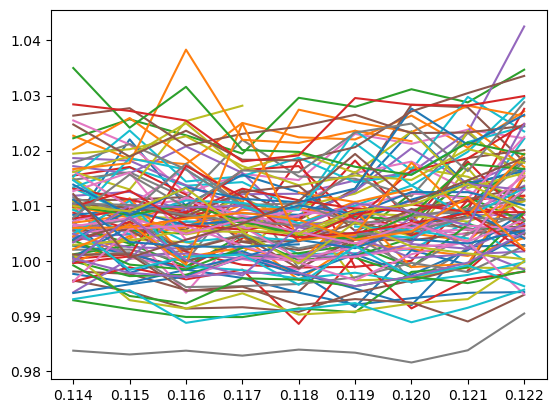

In [13]:
plt.plot(data_crm_posteriori.columns, np.array(data_crm_posteriori.T))

## Taking the Chi2 from the fit Info
They are computed with the t0 prescription

In [17]:
min_values = {}
for alpha, flist in as_fits.items():
    series = []
    for f in flist:
        s = [measure(d) for d in replica_data[f]]
        series.append(pd.Series(s, index=indexes[f]))
    min_values[alpha] = pd.DataFrame(series).min()
data_crm = pd.DataFrame(min_values)

In [18]:
mins_crm = fit_parabola(data_crm)
describe_results(mins_crm)

count    91.000000
mean      0.144609
std       0.168716
min      -0.221494
16%       0.121606
50%       0.129747
84%       0.143510
max       1.653003
dtype: float64

cv±std = 0.14461 ± 0.16872 
1std interval:  -0.02411 to 0.31333 
68% c.i:        0.12161 to 0.14351 


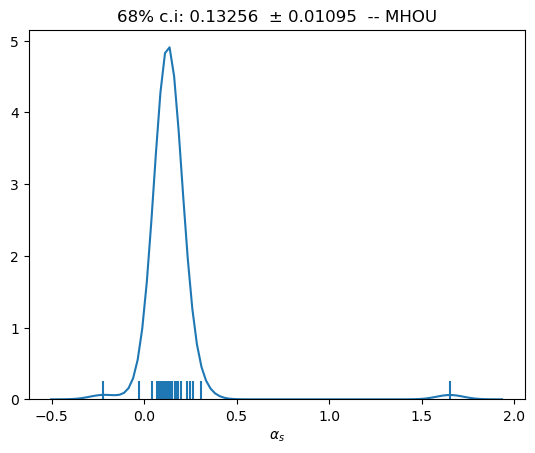

In [19]:
plot_results(mins_crm)

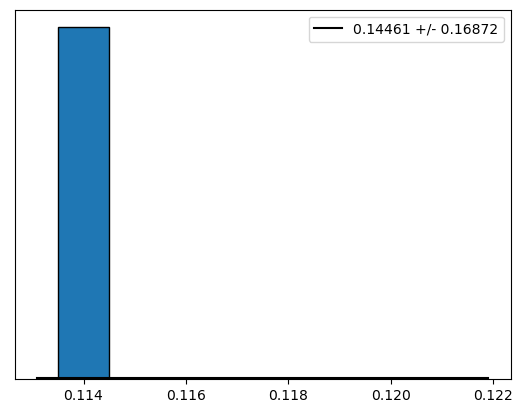

In [20]:
hist_results(mins_crm, data_crm)

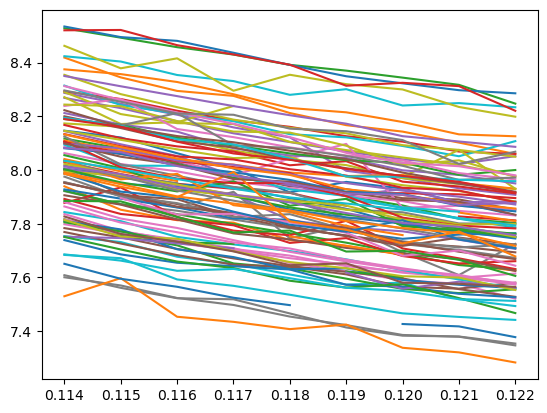

In [21]:
plt.plot(data_crm.columns, np.array(data_crm.T))

# Experimental ("naive") method

First we try computing the chi2 for the replica 0

In [14]:
central_chi2 = {}
for alpha, flist in as_fits.items():
    chi2s_replica0 = []
    for f in flist:
        config_common["fit"] = f.name
        config_common["fits"] = [f.name] #This is used only to load replica 1 data, and it currently needs a list of fits
        chi2s_replica0.append(API.central_chi2_level1(**config_common)) #This function is only present in the branch closure_with_same_level1
    central_chi2[alpha] = pd.DataFrame(chi2s_replica0).min()
data_expmeth_replica0 = pd.DataFrame(central_chi2)

LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240311-ab-ct-alphas114-noMHOU_DIS/240311-ab-ct-alphas114-noMHOU_DIS_0000.dat
240311-ab-ct-alphas114-noMHOU_DIS PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240311-ab-ct-alphas115-noMHOU_DIS/240311-ab-ct-alphas115-noMHOU_DIS_0000.dat
240311-ab-ct-alphas115-noMHOU_DIS PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240311-ab-ct-alphas116-noMHOU_DIS/240311-ab-ct-alphas116-noMHOU_DIS_0000.dat
240311-ab-ct-alphas116-noMHOU_DIS PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240311-ab-ct-alphas117-noMHOU_DIS/240311-ab-ct-alphas117-noMHOU_DIS_0000.dat
240311-ab-ct-alphas117-noMHOU_DIS PDF set, member #0, version 1
LHAPDF 6.4.0 loading /Users/andrea/miniconda3/envs/nnpdf/share/LHAPDF/240311-ab-ct-alphas118-noMHOU_DIS/240311-ab-ct-alphas118-noMHOU_DIS_0000.dat
240311-ab

cv±std = 0.11765 ± 0.00101 


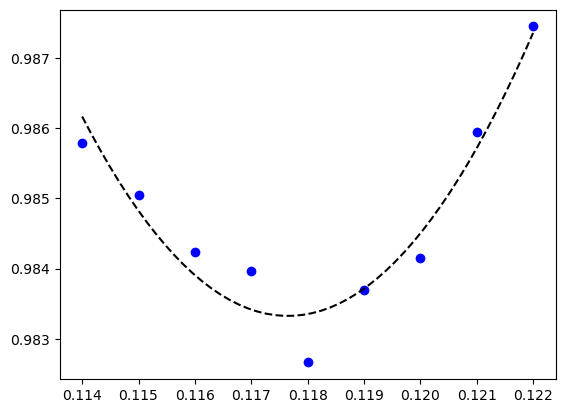

In [15]:
min_exp_meth, uncer = fit_parabola(data_expmeth_replica0, exp=True)
print(f"cv±std = {min_exp_meth:.5f} ± {uncer:.5f} ")

In [ ]:
central_chi2_replicas = {}
for alpha, flist in as_fits.items():
    chi2s_replicas = []
    for f in flist:
        config_common["fit"] = f.name
        config_common["fits"] = [f.name] #This is used only to load replica 1 data, and it currently needs a list of fits
        chi2s_replicas.append(np.mean(API.replica_chi2_level1(**config_common))) #This function is only present in the branch closure_with_same_level1
    central_chi2_replicas[alpha] = pd.DataFrame(chi2s_replicas).min()
data_expmeth_replicas = pd.DataFrame(central_chi2_replicas)

In [ ]:
min_exp_meth_replicas, uncer_replicas = fit_parabola(data_expmeth_replicas, exp=True)
print(f"cv±std = {min_exp_meth_replicas:.5f} ± {uncer_replicas:.5f} ")

## Fixed PDF at alphas=0.118

In [ ]:
central_chi2_fixedpdf = {}
for alpha, flist in as_fits.items():
    chi2s_replica0 = []
    for f in flist: 
        config_common["fit"] = f.name
        config_common["fits"] = [f.name] #This is used only to load replica 1 data, and it currently needs a list of fits
        config_common["pdf"] = "240311-ab-ct-alphas118-noMHOU_DIS_noGPOS"
        chi2s_replica0.append(API.central_chi2_level1(**config_common)) #This function is only present in the branch closure_with_same_level1
    central_chi2_fixedpdf[alpha] = pd.DataFrame(chi2s_replica0).min()
data_expmeth_replica0_fixedpdf = pd.DataFrame(central_chi2_fixedpdf)

In [ ]:
min_exp_meth_fixedpdf, uncer = fit_parabola(data_expmeth_replica0_fixedpdf, exp=True)
print(f"cv±std = {min_exp_meth_fixedpdf:.5f} ± {uncer:.5f} ")